In [1]:
# !pip install torch==2.2.0
# !pip install torchtext==0.17.2
# !pip install torchdata==0.7.1
# !pip install transformers==4.35.2
# !pip install seaborn

In [2]:
import os
os.chdir("..")

In [3]:
from src.dataloader import get_dataloaders
from src.model import CustomGPTModel
from src.engine import train_one_epoch, evaluate
from src.utils import generate_text, setup_logging
from src.config import *

import torch
import torch.nn as nn
import time

import matplotlib.pyplot as plt
from typing import List
from torch.optim.lr_scheduler import StepLR

In [4]:
EXPERIMENT_DIR = 'runs/epoch_1_20_v2'
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
best_model_path = os.path.join(EXPERIMENT_DIR, "best_model.pth")
checkpoint_path = os.path.join(EXPERIMENT_DIR, "latest_checkpoint.pth")
log_file_path = os.path.join(EXPERIMENT_DIR, "training.log")

In [5]:
logger = setup_logging(log_file_path)

In [13]:
train_dataloader, val_dataloader, test_dataloader, vocab = get_dataloaders(
    processed_data_path=PROCESSED_DATA_PATH,
    vocab_path=VOCAB_PATH,
    tokenizer=tokenizer,
    block_size=BLOCK_SIZE,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    PAD_IDX=PAD_IDX,
    END_OF_TEXT_TOKEN=END_OF_TEXT_TOKEN
)

Loading pre-processed data and vocabulary...
Vocabulary Size: 39270
Loading complete.

--- Inspecting a single batch from the train_dataloader ---
Shape of the source (src) batch:	torch.Size([64, 64]) -> [sequence_length, batch_size]
Shape of the target (tgt) batch:	torch.Size([64, 64]) -> [sequence_length, batch_size]

--- Inspecting the first example in the batch ---
Shape of a single source example:	torch.Size([64])

Decoded Source (Input to Model):
'this should have made me think about anything in the <unk> the unnoticed girl is on her way to commit suicide was i the only person cheering her on the clichd classical music long tracking shots melancholy emotion of the film by that stage had me in reversal to what was intended i would have only been happy if she walked into the room'

Decoded Target (What Model Predicts):
'should have made me think about anything in the <unk> the unnoticed girl is on her way to commit suicide was i the only person cheering her on the clichd classical 

In [7]:
VOCAB_SIZE = len(vocab)

In [8]:
VOCAB_SIZE

39270

In [10]:
model = CustomGPTModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    max_seq_len=BLOCK_SIZE
).to(DEVICE)



NUM_EPOCHS = 30

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003) 
scheduler = StepLR(optimizer, step_size=1, gamma=1.0) 
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [12]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,}")

Total Trainable Parameters: 52,861,286


In [ ]:
train_losses, train_accuracies, train_perplexities = [], [], []
val_losses, val_accuracies, val_perplexities = [], [], []

start_epoch = 1
best_val_loss = float('inf')

logger.info(f"Starting training for {NUM_EPOCHS} epochs on device: {DEVICE}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss, train_acc, train_ppl = train_one_epoch(model, train_dataloader, loss_fn, optimizer, scheduler, DEVICE)
    val_loss, val_acc, val_ppl = evaluate(model, val_dataloader, loss_fn, DEVICE)
    
    epoch_duration = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_perplexities.append(train_ppl)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_perplexities.append(val_ppl)

    log_message = (
    f"| Epoch {epoch:3d}/{NUM_EPOCHS:3d} | Time: {epoch_duration:5.2f}s | LR: {current_lr:.6f} | "
    f"Train Loss: {train_loss:5.3f}, PPL: {train_ppl:8.2f}, Acc: {train_acc*100:5.2f}% | "
    f"Val Loss: {val_loss:5.3f}, PPL: {val_ppl:8.2f}, Acc: {val_acc*100:5.2f}% |"
    )
    logger.info(log_message)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        logger.info(f"-> New best model saved to '{best_model_path}' with validation loss: {best_val_loss:.3f}")


    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'train_perplexities': train_perplexities,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_perplexities': val_perplexities
        
    }, checkpoint_path)

2025-08-15 18:37:39,835 - INFO - Starting training for 30 epochs on device: cuda


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.96it/s]

2025-08-15 18:38:43,830 - INFO - | Epoch   1/ 30 | Time: 63.99s | LR: 0.000300 | Train Loss: 6.769, PPL:   870.32, Acc:  6.78% | Val Loss: 6.326, PPL:   559.09, Acc:  9.75% |


2025-08-15 18:38:44,875 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 6.326


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]

2025-08-15 18:39:51,648 - INFO - | Epoch   2/ 30 | Time: 63.89s | LR: 0.000300 | Train Loss: 6.166, PPL:   476.05, Acc: 11.01% | Val Loss: 5.926, PPL:   374.60, Acc: 12.65% |


2025-08-15 18:39:52,663 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.926


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]

2025-08-15 18:40:59,538 - INFO - | Epoch   3/ 30 | Time: 64.02s | LR: 0.000300 | Train Loss: 5.839, PPL:   343.29, Acc: 13.13% | Val Loss: 5.669, PPL:   289.73, Acc: 14.37% |


2025-08-15 18:41:00,569 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.669


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]

2025-08-15 18:42:07,372 - INFO - | Epoch   4/ 30 | Time: 63.90s | LR: 0.000300 | Train Loss: 5.608, PPL:   272.72, Acc: 14.79% | Val Loss: 5.493, PPL:   243.09, Acc: 15.88% |


2025-08-15 18:42:08,471 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.493


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]

2025-08-15 18:43:15,444 - INFO - | Epoch   5/ 30 | Time: 64.02s | LR: 0.000300 | Train Loss: 5.438, PPL:   229.93, Acc: 15.99% | Val Loss: 5.354, PPL:   211.47, Acc: 16.84% |


2025-08-15 18:43:16,482 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.354


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]

2025-08-15 18:44:23,313 - INFO - | Epoch   6/ 30 | Time: 63.93s | LR: 0.000300 | Train Loss: 5.295, PPL:   199.38, Acc: 16.98% | Val Loss: 5.256, PPL:   191.68, Acc: 17.67% |


2025-08-15 18:44:24,347 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.256


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.59it/s]

2025-08-15 18:45:31,197 - INFO - | Epoch   7/ 30 | Time: 63.95s | LR: 0.000300 | Train Loss: 5.178, PPL:   177.40, Acc: 17.77% | Val Loss: 5.172, PPL:   176.19, Acc: 18.27% |


2025-08-15 18:45:32,281 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.172


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s]

2025-08-15 18:46:39,038 - INFO - | Epoch   8/ 30 | Time: 63.88s | LR: 0.000300 | Train Loss: 5.076, PPL:   160.21, Acc: 18.42% | Val Loss: 5.118, PPL:   166.93, Acc: 18.75% |


2025-08-15 18:46:40,072 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.118


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]

2025-08-15 18:47:46,945 - INFO - | Epoch   9/ 30 | Time: 63.93s | LR: 0.000300 | Train Loss: 4.990, PPL:   146.88, Acc: 18.96% | Val Loss: 5.088, PPL:   162.07, Acc: 19.17% |


2025-08-15 18:47:47,984 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.088


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]

2025-08-15 18:48:54,804 - INFO - | Epoch  10/ 30 | Time: 63.91s | LR: 0.000300 | Train Loss: 4.915, PPL:   136.27, Acc: 19.42% | Val Loss: 5.044, PPL:   155.11, Acc: 19.53% |


2025-08-15 18:48:55,832 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.044


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.70it/s]

2025-08-15 18:50:02,633 - INFO - | Epoch  11/ 30 | Time: 63.92s | LR: 0.000300 | Train Loss: 4.841, PPL:   126.61, Acc: 19.88% | Val Loss: 5.020, PPL:   151.35, Acc: 19.79% |


2025-08-15 18:50:03,523 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.020


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.79it/s]

2025-08-15 18:51:10,422 - INFO - | Epoch  12/ 30 | Time: 63.94s | LR: 0.000300 | Train Loss: 4.780, PPL:   119.15, Acc: 20.23% | Val Loss: 5.013, PPL:   150.43, Acc: 19.84% |


2025-08-15 18:51:11,472 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 5.013


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]

2025-08-15 18:52:18,283 - INFO - | Epoch  13/ 30 | Time: 63.89s | LR: 0.000300 | Train Loss: 4.719, PPL:   112.05, Acc: 20.58% | Val Loss: 4.990, PPL:   146.95, Acc: 20.09% |


2025-08-15 18:52:19,413 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 4.990


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.54it/s]

2025-08-15 18:53:26,310 - INFO - | Epoch  14/ 30 | Time: 63.95s | LR: 0.000300 | Train Loss: 4.662, PPL:   105.82, Acc: 21.01% | Val Loss: 4.985, PPL:   146.17, Acc: 20.15% |


2025-08-15 18:53:27,365 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 4.985


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.57it/s]

2025-08-15 18:54:34,190 - INFO - | Epoch  15/ 30 | Time: 63.93s | LR: 0.000300 | Train Loss: 4.611, PPL:   100.56, Acc: 21.30% | Val Loss: 4.985, PPL:   146.27, Acc: 20.29% |



Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.67it/s]

2025-08-15 18:55:40,899 - INFO - | Epoch  16/ 30 | Time: 63.93s | LR: 0.000300 | Train Loss: 4.557, PPL:    95.33, Acc: 21.70% | Val Loss: 4.975, PPL:   144.80, Acc: 20.36% |


2025-08-15 18:55:41,983 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 4.975


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.96it/s]

2025-08-15 18:56:48,935 - INFO - | Epoch  17/ 30 | Time: 64.10s | LR: 0.000300 | Train Loss: 4.512, PPL:    91.12, Acc: 22.02% | Val Loss: 4.967, PPL:   143.55, Acc: 20.41% |


2025-08-15 18:56:49,964 - INFO - -> New best model saved to 'runs/epoch_1_20_v2/best_model.pth' with validation loss: 4.967


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.98it/s]

2025-08-15 18:57:56,730 - INFO - | Epoch  18/ 30 | Time: 63.91s | LR: 0.000300 | Train Loss: 4.468, PPL:    87.18, Acc: 22.37% | Val Loss: 4.976, PPL:   144.92, Acc: 20.44% |



Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.05it/s]

2025-08-15 18:59:03,619 - INFO - | Epoch  19/ 30 | Time: 63.89s | LR: 0.000300 | Train Loss: 4.424, PPL:    83.46, Acc: 22.68% | Val Loss: 4.981, PPL:   145.67, Acc: 20.44% |



Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.01it/s]

2025-08-15 19:00:10,424 - INFO - | Epoch  20/ 30 | Time: 63.94s | LR: 0.000300 | Train Loss: 4.381, PPL:    79.95, Acc: 23.05% | Val Loss: 4.982, PPL:   145.70, Acc: 20.59% |



Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s]

2025-08-15 19:01:17,524 - INFO - | Epoch  21/ 30 | Time: 64.07s | LR: 0.000300 | Train Loss: 4.346, PPL:    77.13, Acc: 23.36% | Val Loss: 4.971, PPL:   144.21, Acc: 20.68% |



Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.04it/s]

2025-08-15 19:02:24,420 - INFO - | Epoch  22/ 30 | Time: 63.94s | LR: 0.000300 | Train Loss: 4.306, PPL:    74.12, Acc: 23.68% | Val Loss: 4.982, PPL:   145.70, Acc: 20.68% |



Training Epoch:  12%|█▏        | 75/625 [00:07<00:53, 10.29it/s, loss=4.2304, acc=0.2437]

In [4]:
def plot_history(
    train_losses: List[float],
    val_losses: List[float],
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_perplexities: List[float],
    val_perplexities: List[float]
):
    """
    Plots the training and validation metrics over epochs.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # --- Subplot 1: Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Subplot 2: Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # --- Subplot 3: Perplexity ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_perplexities, 'bo-', label='Training Perplexity')
    plt.plot(epochs, val_perplexities, 'ro-', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

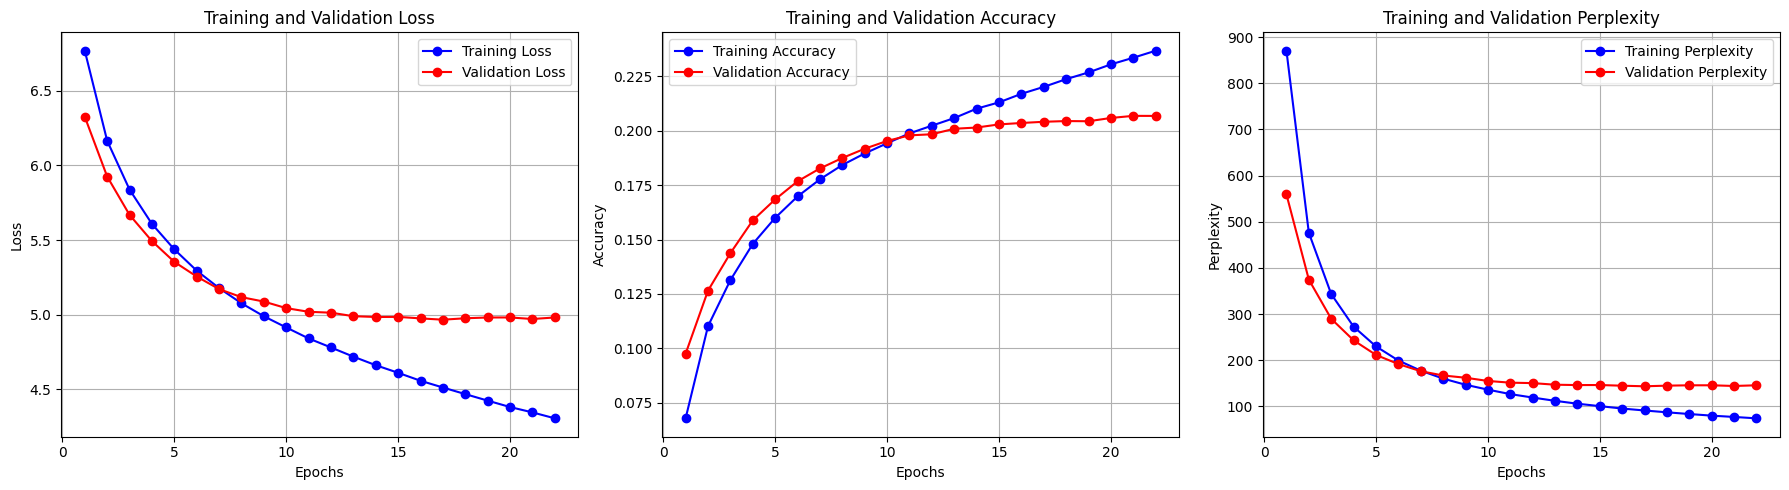

In [5]:
# plot_history(
#     train_losses,
#     val_losses,
#     train_accuracies,
#     val_accuracies,
#     train_perplexities,
#     val_perplexities
# )

EXPERIMENT_DIR = 'runs/epoch_1_20_v2'
checkpoint_path = os.path.join(EXPERIMENT_DIR, "latest_checkpoint.pth")
checkpoint = torch.load(checkpoint_path)
plot_history(
    checkpoint['train_losses'],
    checkpoint['val_losses'],
    checkpoint['train_accuracies'],
    checkpoint['val_accuracies'],
    checkpoint['train_perplexities'],
    checkpoint['val_perplexities']
)

In [7]:
best_model_path = os.path.join(EXPERIMENT_DIR, "best_model.pth")

In [8]:
best_model_path

'runs/epoch_1_20_v2/best_model.pth'

In [11]:
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model weights from '{best_model_path}' for inference.")
else:
    print("No best model found. Using the last trained model for inference.")

Loaded best model weights from 'runs/epoch_1_20_v2/best_model.pth' for inference.


In [14]:
prompt = "I think this movie was"

# 3. Generate the text
print("\n--- Generating Text ---")
generated_text = generate_text(
    model=model,
    prompt=prompt,
    tokenizer=tokenizer,
    vocab=vocab,
    block_size=BLOCK_SIZE,
    max_new_tokens=100,  # Generate 100 new tokens
    device=DEVICE
)

# 4. Print the final result
print(f"\nPrompt: '{prompt}'")
print("-" * 50)
print(f"Generated Text:\n'{generated_text}'")
print("-" * 50)


--- Generating Text ---

Prompt: 'I think this movie was'
--------------------------------------------------
Generated Text:
'i think this movie was a bit too much for me but i was pleasantly surprised by the acting and the story line i was disappointed with the movie the plot was pretty weak and the acting was pretty good but the story was pretty weak and the plot was weak the plot was weak and the acting was pretty good but the movie was a little too long and the plot was pretty weak the plot was pretty weak and the acting was pretty good but the movie was a little too long and the plot was pretty much a little too much to'
--------------------------------------------------


In [15]:
model.eval()

prompts_to_test = [
    "This is one of the best films I have ever seen.",
    "The plot was full of holes and the characters were",
    "The story is about a young detective who discovers",
    "That one scene with the car was just"
]

print("--- Starting Batch Generation ---")

for prompt in prompts_to_test:
    generated_text = generate_text(
        model=model,
        prompt=prompt,
        tokenizer=tokenizer,
        vocab=vocab,
        block_size=BLOCK_SIZE,
        max_new_tokens=50,  # Generate 50 new tokens for each prompt
        device=DEVICE
    )
    
    print("-" * 80)
    print(f"PROMPT: '{prompt}'")
    print(f"\nGENERATED: '{generated_text}'\n")

print("--- Batch Generation Complete ---")

--- Starting Batch Generation ---
--------------------------------------------------------------------------------
PROMPT: 'This is one of the best films I have ever seen.'

GENERATED: 'this is one of the best films i have ever seen <unk> is a great film and i have seen it times over and over again and again and again i have seen it times over and over again and again and again i have seen it again and again and again and again and again i have seen it again and'

--------------------------------------------------------------------------------
PROMPT: 'The plot was full of holes and the characters were'

GENERATED: 'the plot was full of holes and the characters were so underdeveloped that they were not even close to the original story the plot was so weak and the acting was so bad that i couldnt care less about the characters and the plot was so bad that i couldnt care less about the characters and the plot was so'

----------------------------------------------------------------------